# 1. Standard (not graph) AE + GNN for node classification from AE codings

## 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from utils import *

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph
def create_knn_graph(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    return knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main():
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)
    
    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:1000]
    y_subset = y_train[:1000]
    
    # Create KNN graph
    k = 10  # Number of neighbors
    knn_graph = create_knn_graph(x_subset, k)
    
    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features
    
    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")
    
    return data



data = main()
generate_train_test(data)

# # Load the Cora dataset
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



# Autoencoder Settings
input_dim = data.num_node_features
hidden_dim = 128
bottleneck_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, bottleneck_dim)

# Training the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion_ae = nn.MSELoss()

for epoch in range(200):
    autoencoder.train()
    optimizer_ae.zero_grad()
    _, reconstructed = autoencoder(data.x)
    loss = criterion_ae(reconstructed, data.x)
    loss.backward()
    optimizer_ae.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Preparing the compressed features for the GNN
autoencoder.eval()
with torch.no_grad():  # Ensure no gradients are computed for the operation within this block
    compressed_features, _ = autoencoder(data.x)
    compressed_features = compressed_features.detach()  # Detach the features from the graph


# Training the GNN
gcn = GCN(bottleneck_dim, hidden_dim, data.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion_gcn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    gcn.train()
    optimizer_gcn.zero_grad()
    out = gcn(compressed_features, data.edge_index)
    loss = criterion_gcn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.17174354195594788
Epoch 10, Loss: 0.062479909509420395
Epoch 20, Loss: 0.045105110853910446
Epoch 30, Loss: 0.037762850522994995
Epoch 40, Loss: 0.030721938237547874
Epoch 50, Loss: 0.027426406741142273
Epoch 60, Loss: 0.025849729776382446
Epoch 70, Loss: 0.02431415393948555
Epoch 80, Loss: 0.02332432009279728
Epoch 90, Loss: 0.022700443863868713
Epoch 100, Loss: 0.021943436935544014
Epoch 110, Loss: 0.021105343475937843
Epoch 120, Loss: 0.020742950960993767
Epoch 130, Loss: 0.020391099154949188
Epoch 140, Loss: 0.019629810005426407
Epoch 150, Loss: 0.018897276371717453
Epoch 160, Loss: 0.01891905441880226
Epoch 170, Loss: 0.0185588039457798
Epoch 180, Loss: 0.017982322722673416
Epoch 190, Loss: 0.017649656161665916
Epoch 0, Loss: 7.387857437133789
Epoch 10, Loss: 1.0902568101882935
Epoch 20, Loss: 0.936389684677124
Epoch 30, Loss: 0.7880605459213257
Epoch 40, Loss: 0.7460613250732422
Epoch 50, Loss: 0.7328201532363892
Epoch 60, Loss: 0.6776239275932312
Epoch 70, Loss:

In [3]:
# Switch model to evaluation mode
gcn.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Forward pass with the test data
    test_out = gcn(compressed_features, data.edge_index)
    # Use the class with the highest probability as the prediction
    test_pred = test_out.argmax(dim=1)
    # Calculate the number of correct predictions in the test set
    correct = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    # Calculate the test accuracy
    test_accuracy = correct / data.test_mask.sum().item()




## 

In [4]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.74


This obviously does not work. Let's try to fix it.

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 2
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 16

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.386296033859253
Epoch: 20, Loss: 1.3863004446029663
Epoch: 30, Loss: 1.3863035440444946
Epoch: 40, Loss: 1.3863048553466797
Epoch: 50, Loss: 1.3863054513931274
Epoch: 60, Loss: 1.386305570602417
Epoch: 70, Loss: 1.3863054513931274
Epoch: 80, Loss: 1.3863054513931274
Epoch: 90, Loss: 1.386305332183838
Epoch: 100, Loss: 1.3863050937652588
Epoch 0, Loss: 2.302290916442871
Epoch 10, Loss: 2.2955856323242188
Epoch 20, Loss: 2.294692039489746
Epoch 30, Loss: 2.295064926147461
Epoch 40, Loss: 2.2920217514038086
Epoch 50, Loss: 2.2958176136016846
Epoch 60, Loss: 2.290653944015503
Epoch 70, Loss: 2.2887964248657227
Epoch 80, Loss: 2.293483018875122
Epoch 90, Loss: 2.292818784713745


## 

In [6]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1050


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [7]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3863842487335205
Epoch: 20, Loss: 1.3865880966186523
Epoch: 30, Loss: 1.3866974115371704
Epoch: 40, Loss: 1.3867110013961792
Epoch: 50, Loss: 1.3866772651672363
Epoch: 60, Loss: 1.3866291046142578
Epoch: 70, Loss: 1.3865814208984375
Epoch: 80, Loss: 1.386539340019226
Epoch: 90, Loss: 1.386504054069519
Epoch: 100, Loss: 1.386474847793579
Epoch 0, Loss: 2.302621603012085
Epoch 10, Loss: 2.2969882488250732
Epoch 20, Loss: 2.2974600791931152
Epoch 30, Loss: 2.2974462509155273
Epoch 40, Loss: 2.2987494468688965
Epoch 50, Loss: 2.288996458053589
Epoch 60, Loss: 2.298806667327881
Epoch 70, Loss: 2.293795585632324
Epoch 80, Loss: 2.2861623764038086
Epoch 90, Loss: 2.2776827812194824


## 

In [9]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1450


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [10]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862969875335693
Epoch: 20, Loss: 1.3863017559051514
Epoch: 30, Loss: 1.3863046169281006
Epoch: 40, Loss: 1.386305809020996
Epoch: 50, Loss: 1.3863059282302856
Epoch: 60, Loss: 1.386305570602417
Epoch: 70, Loss: 1.3863050937652588
Epoch: 80, Loss: 1.386304497718811
Epoch: 90, Loss: 1.3863039016723633
Epoch: 100, Loss: 1.386303424835205


## 

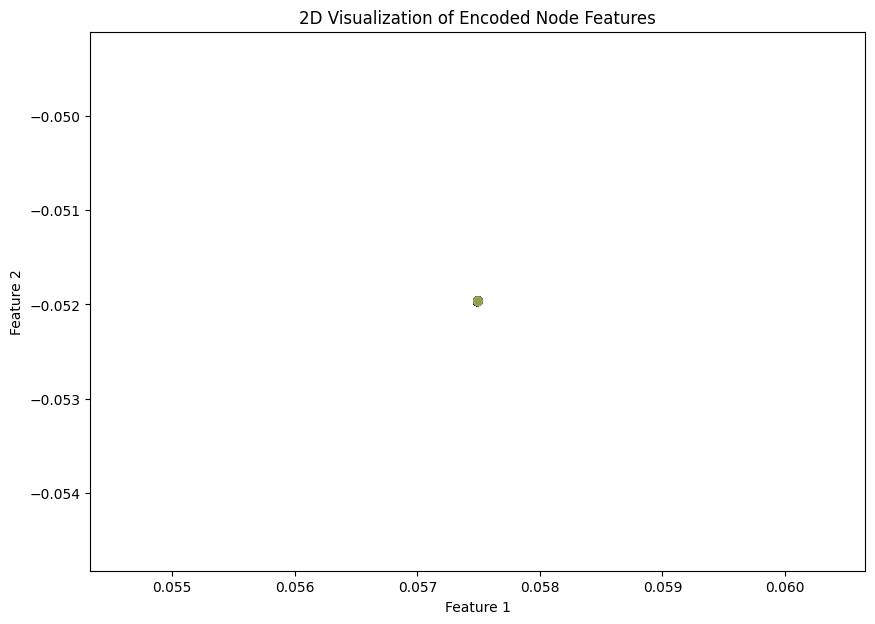

In [12]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [13]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 1.3733978271484375
Epoch: 20, Loss: 1.3866727352142334
Epoch: 30, Loss: 1.3870182037353516
Epoch: 40, Loss: 1.3870747089385986
Epoch: 50, Loss: 1.3870564699172974
Epoch: 60, Loss: 1.3870060443878174
Epoch: 70, Loss: 1.3869421482086182
Epoch: 80, Loss: 1.3868770599365234
Epoch: 90, Loss: 1.3868162631988525
Epoch: 100, Loss: 1.3867614269256592
Epoch: 110, Loss: 1.3867123126983643
Epoch: 120, Loss: 1.386669397354126
Epoch: 130, Loss: 1.386631727218628
Epoch: 140, Loss: 1.3865981101989746
Epoch: 150, Loss: 1.3865687847137451
Epoch: 160, Loss: 1.386542797088623
Epoch: 170, Loss: 1.3865199089050293
Epoch: 180, Loss: 1.3864996433258057
Epoch: 190, Loss: 1.3864814043045044
Epoch: 200, Loss: 1.3864656686782837


## 

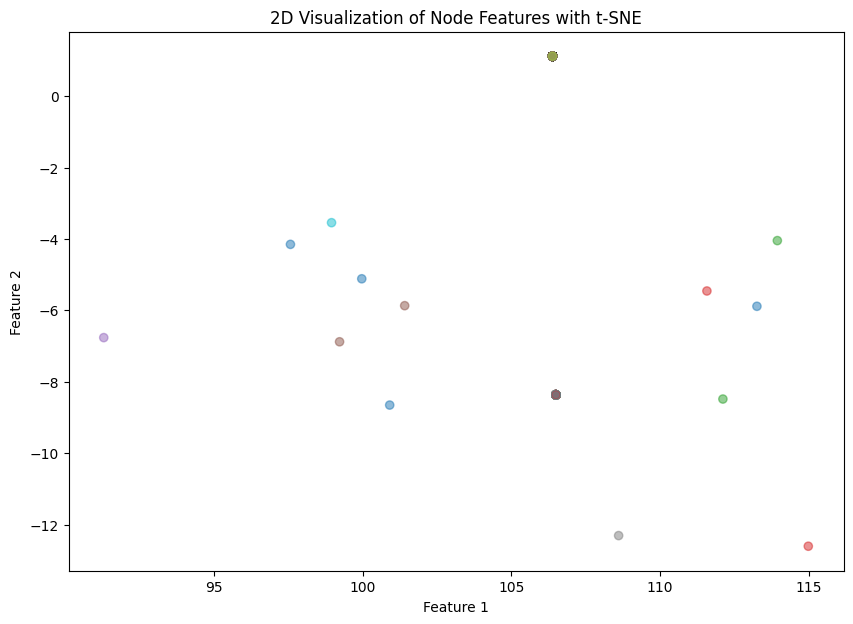

In [15]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [16]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [17]:
class EnhancedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedGCNEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.base_conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)  # Skip connection
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = F.relu(self.base_conv2(x + skip1, edge_index))  # Combine with skip connection
        return self.conv3(x, edge_index)

# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.8027054071426392
Epoch: 20, Loss: 1.2358067035675049
Epoch: 30, Loss: 1.1431553363800049
Epoch: 40, Loss: 1.0711865425109863
Epoch: 50, Loss: 1.0120729207992554
Epoch: 60, Loss: 0.9939993619918823
Epoch: 70, Loss: 0.9721662998199463
Epoch: 80, Loss: 0.9786730408668518
Epoch: 90, Loss: 0.9700726866722107
Epoch: 100, Loss: 0.9639142751693726
Epoch: 110, Loss: 0.9556427001953125
Epoch: 120, Loss: 0.9491326212882996
Epoch: 130, Loss: 0.9237460494041443
Epoch: 140, Loss: 0.9511160850524902
Epoch: 150, Loss: 0.9491981863975525
Epoch: 160, Loss: 0.9357088804244995
Epoch: 170, Loss: 0.9279534220695496
Epoch: 180, Loss: 0.9341172575950623
Epoch: 190, Loss: 0.93060702085495
Epoch: 200, Loss: 0.9199385643005371


## 

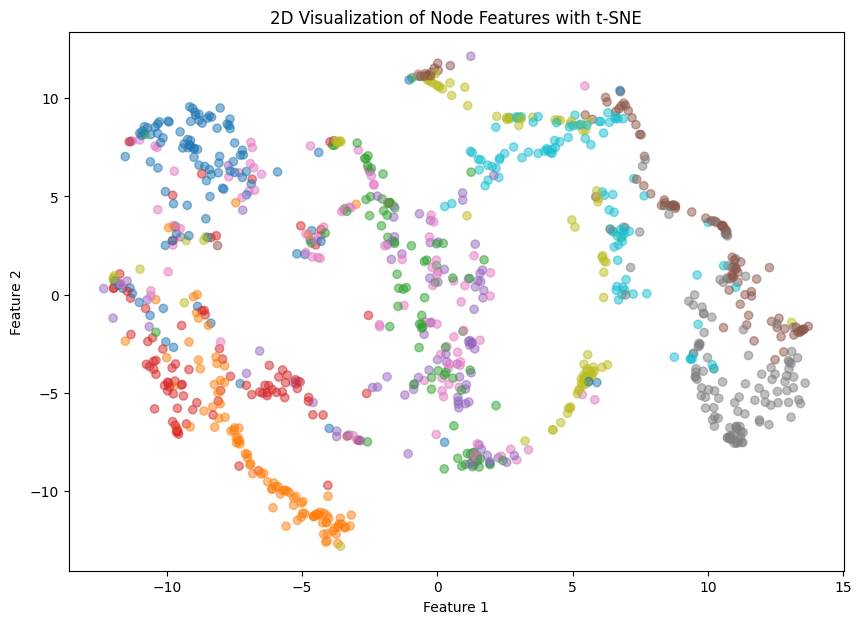

In [18]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [19]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [20]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.312756061553955
Epoch: 20, Loss: 1.279167890548706
Epoch: 30, Loss: 1.2490768432617188
Epoch: 40, Loss: 1.2290433645248413
Epoch: 50, Loss: 1.1978403329849243
Epoch: 60, Loss: 1.1823242902755737
Epoch: 70, Loss: 1.159449577331543
Epoch: 80, Loss: 1.1403870582580566
Epoch: 90, Loss: 1.1403701305389404
Epoch: 100, Loss: 1.141223430633545


## 

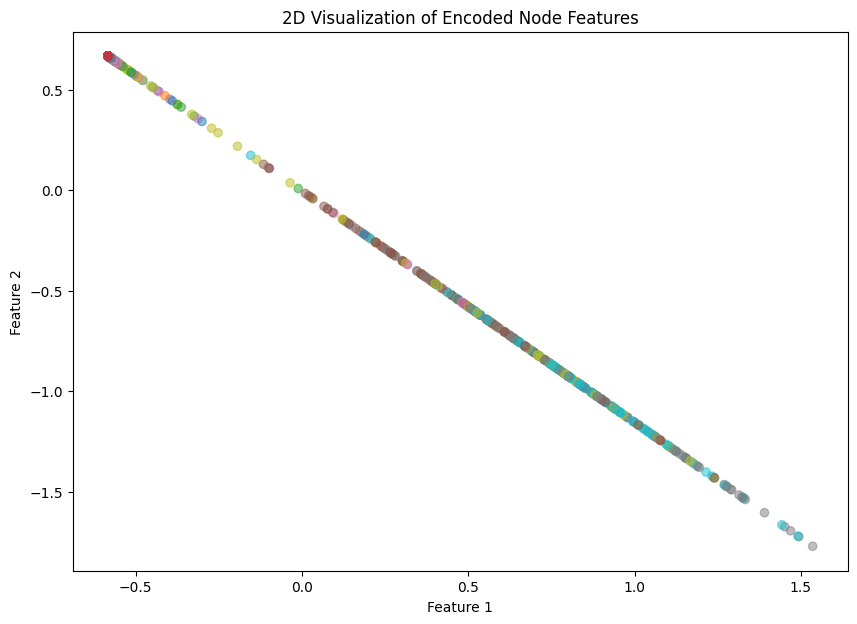

In [21]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

## 

In [22]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [23]:
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        # Concatenate multi-head outputs so the final output will be 2*out_channels*8
        self.conv2 = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 7.351086616516113
Epoch: 20, Loss: 5.9784932136535645
Epoch: 30, Loss: 5.516151428222656
Epoch: 40, Loss: 4.6242499351501465
Epoch: 50, Loss: 4.318922996520996
Epoch: 60, Loss: 2.866550922393799
Epoch: 70, Loss: 2.1339809894561768
Epoch: 80, Loss: 1.9470491409301758
Epoch: 90, Loss: 1.5576553344726562
Epoch: 100, Loss: 1.6689234972000122
Epoch: 110, Loss: 1.5645756721496582
Epoch: 120, Loss: 1.5680427551269531
Epoch: 130, Loss: 1.5462512969970703
Epoch: 140, Loss: 1.4772233963012695
Epoch: 150, Loss: 1.4526405334472656
Epoch: 160, Loss: 1.4048757553100586
Epoch: 170, Loss: 1.4187376499176025
Epoch: 180, Loss: 1.4500541687011719
Epoch: 190, Loss: 1.3903536796569824
Epoch: 200, Loss: 1.4542182683944702


## 

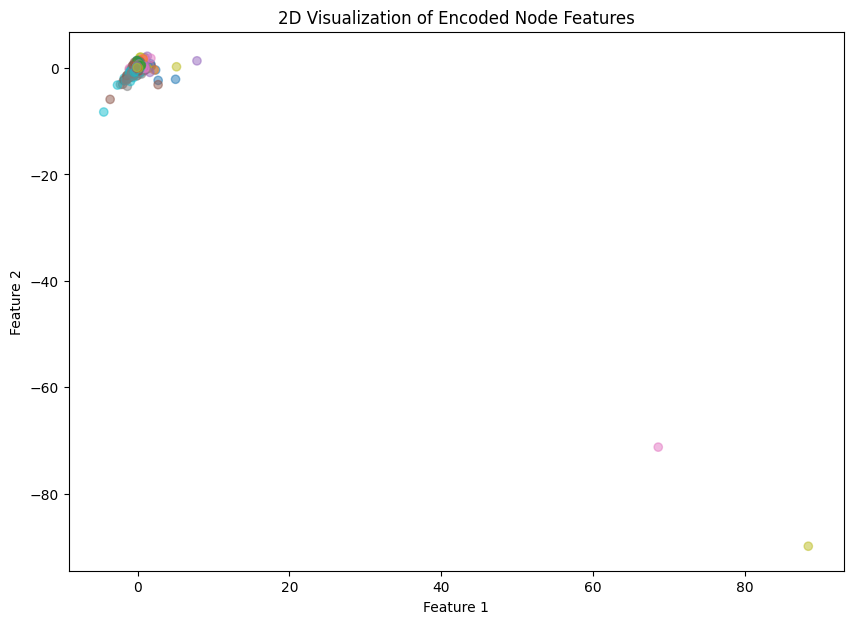

In [24]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [25]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [26]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 7.682753562927246
Epoch: 20, Loss: 7.596095561981201
Epoch: 30, Loss: 6.74290657043457
Epoch: 40, Loss: 6.54068660736084
Epoch: 50, Loss: 7.016212463378906
Epoch: 60, Loss: 6.624067783355713
Epoch: 70, Loss: 5.975937366485596
Epoch: 80, Loss: 7.15443229675293
Epoch: 90, Loss: 6.707668304443359
Epoch: 100, Loss: 7.3117475509643555
Epoch: 110, Loss: 6.5289740562438965
Epoch: 120, Loss: 6.466732978820801
Epoch: 130, Loss: 6.320563316345215
Epoch: 140, Loss: 5.3033552169799805
Epoch: 150, Loss: 8.22394847869873
Epoch: 160, Loss: 6.589072227478027
Epoch: 170, Loss: 6.149651527404785
Epoch: 180, Loss: 11.594208717346191
Epoch: 190, Loss: 17.08317756652832
Epoch: 200, Loss: 11.952383041381836


## 

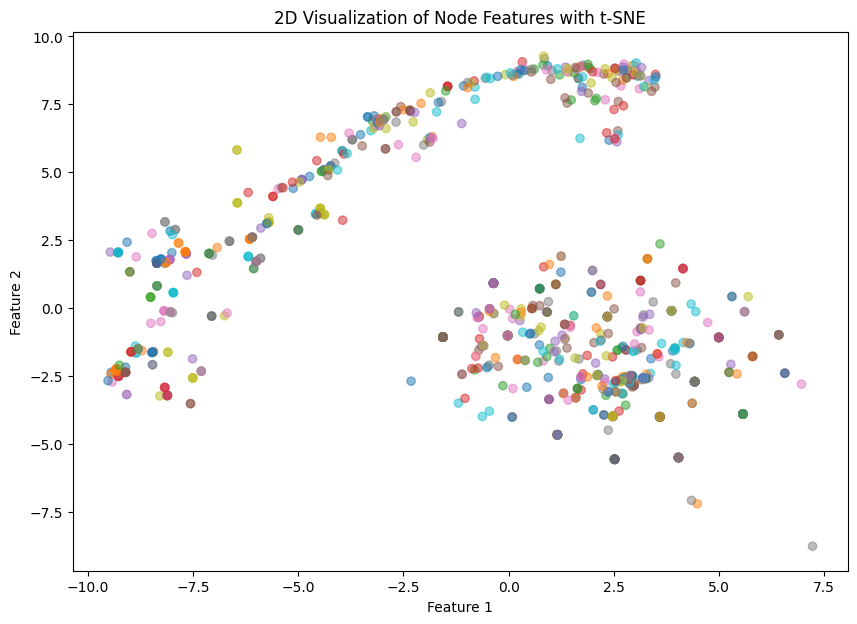

In [27]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [28]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [29]:
class ComplexGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexGCNEncoder, self).__init__()
        # Encoder with skip connections
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.skip_conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) + x  # Residual connection
        x = self.conv3(x, edge_index) + skip1  # Skip connection
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ComplexGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.4601331949234009
Epoch: 20, Loss: 1.396677017211914
Epoch: 30, Loss: 1.1749924421310425
Epoch: 40, Loss: 1.1495037078857422
Epoch: 50, Loss: 1.1449310779571533
Epoch: 60, Loss: 1.1387590169906616
Epoch: 70, Loss: 1.1269330978393555
Epoch: 80, Loss: 1.129273533821106
Epoch: 90, Loss: 1.1217339038848877
Epoch: 100, Loss: 1.1254379749298096
Epoch: 110, Loss: 1.1101405620574951
Epoch: 120, Loss: 1.082541584968567
Epoch: 130, Loss: 1.0551159381866455
Epoch: 140, Loss: 1.0437467098236084
Epoch: 150, Loss: 1.0410364866256714
Epoch: 160, Loss: 1.0283719301223755
Epoch: 170, Loss: 1.0314593315124512
Epoch: 180, Loss: 1.034838318824768
Epoch: 190, Loss: 1.0251888036727905
Epoch: 200, Loss: 1.0299925804138184


## 

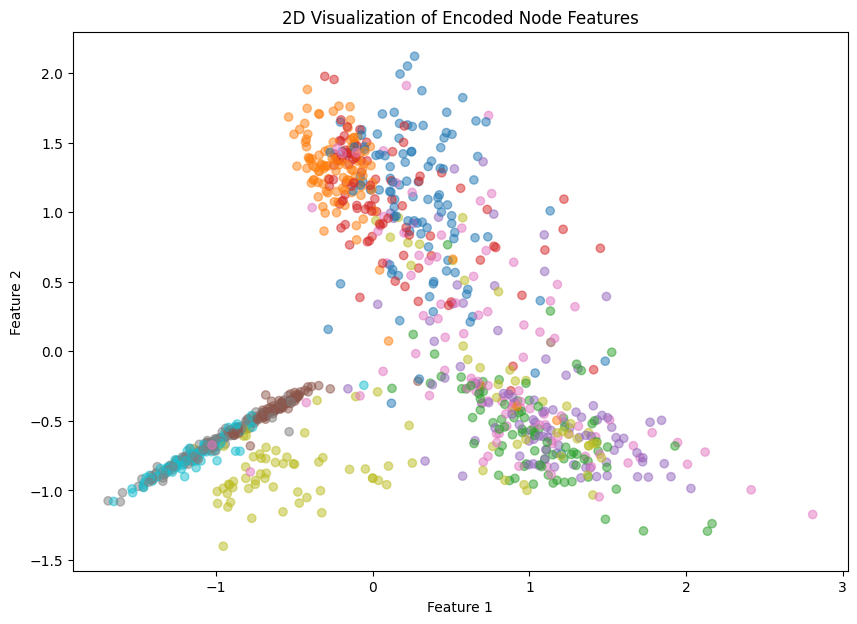

In [30]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [31]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [32]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)
        
        x = self.conv3(x, edge_index)
        
        x += identity  # Add the input to the output
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.539292812347412
Epoch: 20, Loss: 1.2818603515625
Epoch: 30, Loss: 1.1316157579421997
Epoch: 40, Loss: 1.1052345037460327
Epoch: 50, Loss: 1.0694950819015503
Epoch: 60, Loss: 1.0694986581802368
Epoch: 70, Loss: 1.061405897140503
Epoch: 80, Loss: 1.0379061698913574
Epoch: 90, Loss: 1.02587890625
Epoch: 100, Loss: 1.0414520502090454
Epoch: 110, Loss: 1.0362468957901
Epoch: 120, Loss: 1.0186939239501953
Epoch: 130, Loss: 1.024281620979309
Epoch: 140, Loss: 1.0236077308654785
Epoch: 150, Loss: 1.0210611820220947
Epoch: 160, Loss: 1.021623134613037
Epoch: 170, Loss: 1.026625633239746
Epoch: 180, Loss: 1.0160019397735596
Epoch: 190, Loss: 1.029085636138916
Epoch: 200, Loss: 1.0146087408065796


## 

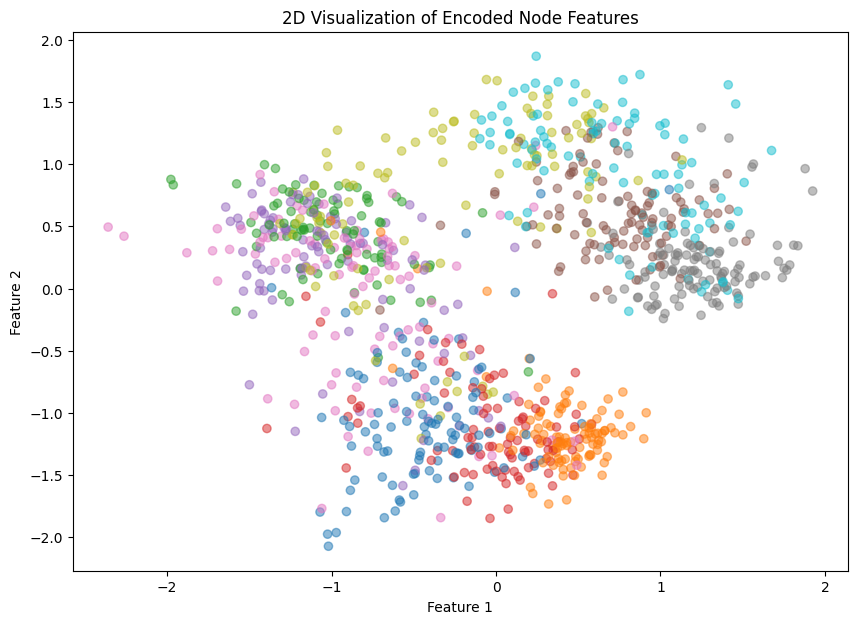

In [33]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [34]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 10000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [35]:
from torch_geometric.nn import GATConv, LayerNorm

class GATWithLayerNormEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout_rate=0.6):
        super(GATWithLayerNormEncoder, self).__init__()
        # Define the first layer with multiple heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # For the second layer, we want to reduce the dimension to our desired output dimension
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)
        # Layer normalization
        self.ln1 = LayerNorm(hidden_channels * heads)
        self.ln2 = LayerNorm(out_channels)

    def forward(self, x, edge_index, dropout_rate=0.6):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(GATWithLayerNormEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.2858630418777466
Epoch: 20, Loss: 1.1964566707611084
Epoch: 30, Loss: 1.1894862651824951
Epoch: 40, Loss: 1.1676290035247803
Epoch: 50, Loss: 1.15804922580719
Epoch: 60, Loss: 1.1569900512695312
Epoch: 70, Loss: 1.1720144748687744
Epoch: 80, Loss: 1.1530213356018066
Epoch: 90, Loss: 1.156294345855713
Epoch: 100, Loss: 1.1330201625823975
Epoch: 110, Loss: 1.1282904148101807
Epoch: 120, Loss: 1.1580970287322998
Epoch: 130, Loss: 1.1367335319519043
Epoch: 140, Loss: 1.1411974430084229
Epoch: 150, Loss: 1.1396087408065796
Epoch: 160, Loss: 1.1413154602050781
Epoch: 170, Loss: 1.1245951652526855
Epoch: 180, Loss: 1.14254629611969
Epoch: 190, Loss: 1.1552008390426636
Epoch: 200, Loss: 1.1400806903839111


## 

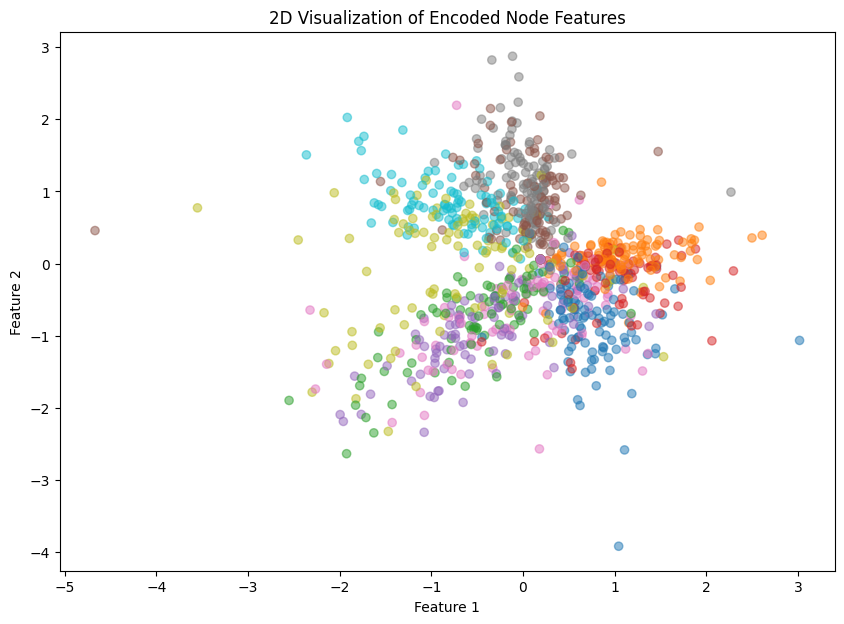

In [36]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')